# **PCA on MNIST Digits**

1. This project explores how **Principal Component Analysis (PCA)** can be applied to the MNIST dataset to gain insight into the structure of handwritten digits.  

2. We demonstrate how PCA can be used to **reduce dimensionality**,**reconstruct images**, and **generate new samples** by sampling from the PCA latent space.

3. The project also compares **global vs class-specific PCA**, highlighting the tradeoffs between information compression and generative quality.

---

**Note:** All computations in this project are implemented using **NumPy only**, with no external machine learning libraries, in order to explicitly demonstrate and understand the mathematical steps behind PCA from first principles.


# 1. Setup
* Import required libraries
* Define custom helper functions

## 1.1 Import Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from tensorflow import keras

from bisect import bisect_right

## 1.2 Define Helper for Mathematical Operations

In [2]:
def standardize(data):

    """Standardize input data to zero mean and unit variance."""

    epsilon = 1e-8
    data_mean = np.mean(data, axis=0)
    data_std_dev = np.std(data, axis=0)
    standardized_data = (data - data_mean) / (data_std_dev + epsilon)

    return standardized_data, data_mean, data_std_dev


def undo_standardize(standardized_data, data_mean, data_std_dev):

    """Undo standardization to recover original scale."""

    epsilon = 1e-8
    original_data = (standardized_data * (data_std_dev + epsilon)) + data_mean

    return original_data


def compute_pca(data_standardized):

    """Compute PCA eigenvalues and eigenvectors using SVD."""

    n_samples = data_standardized.shape[0]
    U, singular_values, Vt = np.linalg.svd(data_standardized.T, full_matrices=False)
    eigenvalues = (singular_values ** 2) / n_samples
    eigenvectors = U

    return eigenvalues, eigenvectors


def project_onto_components(data_standardized, eigenvectors, n_components):

    """Project standardized data onto the top n_components principal components."""

    pca_basis = eigenvectors[:, :n_components]
    data_projected = (pca_basis.T @ data_standardized.T).T

    return data_projected, pca_basis


def reconstruct_from_projected(data_projected, pca_basis):

    """Reconstruct standardized data from its PCA projected representation."""

    reconstructed_standardized_data = (pca_basis @ data_projected.T).T

    return reconstructed_standardized_data


def generate_samples_from_pca(data_projected, pca_basis, data_mean, data_std_dev, n_samples=1):

    """Generate new samples by sampling from PCA projected space."""

    projected_mean = np.mean(data_projected, axis=0)
    projected_covariance = np.cov(data_projected, rowvar=False)
    sampled_data_projected = np.random.multivariate_normal(projected_mean, projected_covariance, size=n_samples)
    generated_standardized_data = reconstruct_from_projected(sampled_data_projected, pca_basis)
    generated_data = undo_standardize(generated_standardized_data, data_mean, data_std_dev)

    return generated_data


## 1.3 Helper Function for Visualisation

In [3]:
def plot_digits_row(images, labels=None, title=None, cmap='magma', figsize=(15, 3)):

    """
    Plot a row of digit images with optional labels.

    Args:
        images (array-like): Array of images, each flattened (shape: [n_samples, 784]).
        labels (array-like, optional): Labels corresponding to images. Default is None.
        title (str, optional): Title for the whole figure. Default is None.
        cmap (str, optional): Colormap for images. Default is 'magma'.
        figsize (tuple, optional): Figure size for the plot. Default is (15, 3).
    """

    n_images = images.shape[0]

    fig, axes = plt.subplots(1, n_images, figsize=figsize)

    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].reshape(28, 28), cmap=cmap)
        ax.axis('off')
        if labels is not None:
            ax.set_title(str(labels[idx]), fontsize=20)

    if title is not None:
        plt.suptitle(title, y=1, fontsize=30)

    plt.tight_layout()
    plt.show()


def plot_eigenvalues(eigenvalues, title=None, marker='.', color='orange', figsize=(8, 5)):

  """
  Plot a chart of eigenvalues vs principal component number.

  Args:
      eigenvalues (array like): Array of eigenvalues obtained after decomposition
      title (str, optional): Title for the whole figure. Default is None.
      marker(str): marker for data point on the plot. Default is '.'.
      color(str): color for chart data points. Default is 'orange'.
      figsize (tuple, optional): Figure size for the plot. Default is (8, 5).
  """

  plt.figure(figsize=figsize)
  plt.plot(eigenvalues, marker=marker, color=color)
  plt.xlabel('Principal Component Index')
  plt.ylabel('Eigenvalue (Variance Captured)')

  if title is not None: plt.title(title)

  plt.grid(True)
  plt.show()


def plot_cumulative_explained_variance(cumulative_explained_variance, title=None, marker='.',
                                       color='orange', figsize=(8, 5)):

  """
  Plot a chart of cum. expl. variance

  Args:
      cumulative_explained_variance (array like): Array of cumulative explined var
      title (str, optional): Title for the whole figure. Default is None.
      marker(str): marker for data point on the plot. Default is '.'.
      color(str): color for chart data points. Default is 'orange'.
      figsize (tuple, optional): Figure size for the plot. Default is (8, 5).

  """

  plt.figure(figsize=figsize)
  plt.plot(cumulative_explained_variance, marker=marker,color=color)
  plt.xlabel('Principal Component Index')
  plt.ylabel('Cumulative Variance Ratio')

  if title is not None: plt.title(title)

  plt.grid(True)
  plt.show()


# 2. Load and Preprocess Data

* Load the full MNIST dataset using Keras.
* Visualize a few sample digits from the original dataset.
* Preprocess the data by reshaping and standardizing it for PCA.


## 2.1 Create the Data Set
* We load the full MNIST dataset (both training and test sets) from Keras.

* Since this project focuses on unsupervised learning (PCA decomposition and generation), we concatenate the training and test data into a single dataset.

* Images are flattened from 28x28 into 784-dimensional vectors. In result we obtain a set of 70,000 flatten images representing digits (0-9).

In [4]:
# Load MNIST dataset from keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Concatenate train and test datasets for unsupervised learning
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

# Flatten images (from 28x28 to 784)
X = X.reshape(X.shape[0], -1)

# Display dataset shapes
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (70000, 784)
Labels shape: (70000,)


## 2.2 Visualize Sample Digits
* We display one representative example of each digit (0–9) on a horizontal 1x10 grid.  

* The images are visualized using the custom `plot_digits_row()` function.

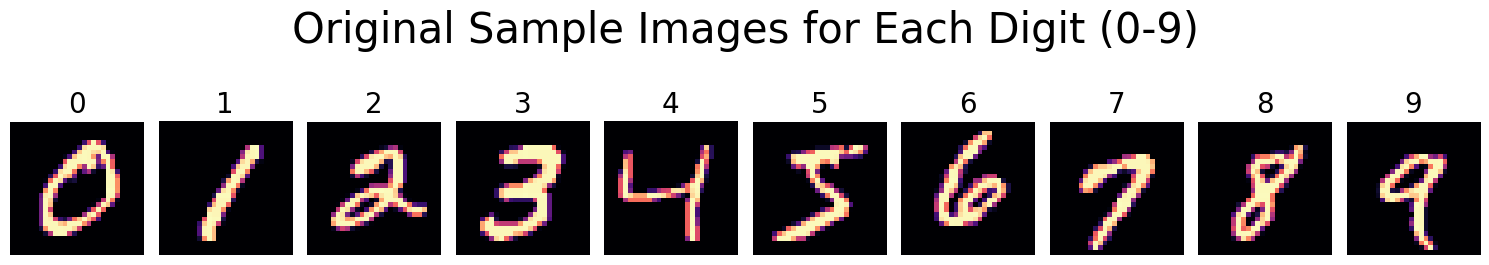

In [5]:
# Extract one sample image for each digit (0–9)
sample_digits = np.zeros((10, 784))

# Predefined labels from 0 to 9
sample_labels=list(range(0,10))

# List to store the indexes of selected samples
sample_indexes = []

# Select the first occurrence of each digit (0–9)
for digit in range(10):
    idx = np.where(y == digit)[0][0]  # Find the first index where label == digit
    sample_digits[digit] = X[idx]
    sample_indexes.append(idx)

# Plot the digits using the helper function
plot_digits_row(sample_digits,
                sample_labels,
                title='Original Sample Images for Each Digit (0-9)'
                )

## 2.3 Standardize Data
* We standardize the pixel values of the images to have zero mean and unit variance using the helper `standardize()` function.

* Standardization ensures that each feature (pixel) contributes equally to the PCA decomposition. That benefits the PCA algorithm, but makes the images less visually interpretable

In [6]:
# Standardize the full dataset
X_standardized, X_mean, X_std_dev = standardize(X)

# Print summary statistics to verify standardization
print(f"Standardized data shape: {X_standardized.shape}")
print(f"Feature-wise mean (approx.): {np.mean(X_standardized):.2e}")
print(f"Feature-wise standard deviation (approx.): {np.std(X_standardized):.2f}")

Standardized data shape: (70000, 784)
Feature-wise mean (approx.): -1.14e-18
Feature-wise standard deviation (approx.): 0.96


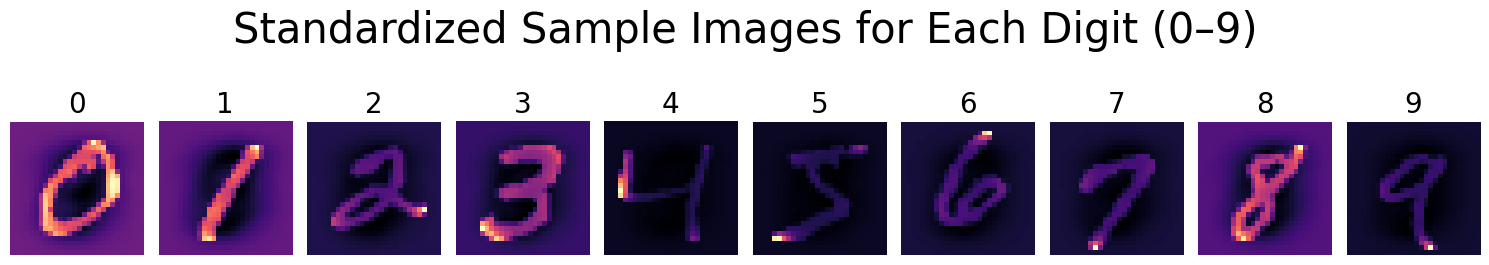

In [7]:
# Standardized digit images from the sample
sample_digits_standardized = X_standardized[sample_indexes]

# Visualize the standardized sample digits
plot_digits_row(
    images=sample_digits_standardized,
    labels=sample_labels,
    title='Standardized Sample Images for Each Digit (0–9)',
    cmap='magma'
)

### How eigenvalues and eigenvectors are obtained via SVD

From the spectral theorem, any symmetric matrix `S` can be diagonalized as:

- `S = P D Pᵀ`,  
  where `P` is an orthonormal basis (ONB) of eigenvectors and `D` is a diagonal matrix of eigenvalues.

In PCA, the covariance matrix `S` of the data `X_standardized` is given by:

- `S = (1/N) X_standardizedᵀ X_standardized`

Applying SVD to `X_standardizedᵀ` gives:

- `X_standardizedᵀ = U Σ Vᵀ`

Thus, we can write:

- `S = (1/N) (U Σ Vᵀ) (V Σᵀ Uᵀ) = (1/N) U (Σ²) Uᵀ`

This shows that:

- `U` contains the eigenvectors (principal directions),
- `Σ² / N` contains the eigenvalues (variance explained).

Therefore, SVD allows us to obtain both the eigenvectors and eigenvalues of the covariance matrix efficiently, without explicitly forming it.


# 3. Principal Component Analysis (PCA)

* Compute principal components using Singular Value Decomposition (SVD).
* Analyze the variance captured by each component and its contribution to data representation.



#### How Eigenvalues and Eigenvectors are Obtained via SVD

In PCA, the principal components are the eigenvectors of the data covariance matrix `S`. These eigenvectors form an orthonormal basis (ONB), and their associated eigenvalues represent the variance projected onto each principal direction.

From the spectral theorem, any symmetric matrix `S` (such as a covariance matrix) can be diagonalized as:

- `S = P D Pᵀ`  
  where `P` is an orthonormal basis of eigenvectors, and `D` is a diagonal matrix of eigenvalues.

For standardized data matrix `X`, the PCA covariance matrix is:

- `S = (1/N) X Xᵀ`

Applying SVD to `X` gives:

- `X = U Σ Vᵀ`

Substituting into `S`, we get:

- `S = (1/N) (U Σ Vᵀ)(V Σᵀ Uᵀ) = (1/N) U Σ² Uᵀ`

This shows that:
- `U` contains the eigenvectors (principal directions),
- `Σ² / N` contains the eigenvalues (variance explained by each component).

Thus, SVD allows us to compute the principal components directly from the data matrix, without explicitly forming the covariance matrix.

**Note**: We transpose the data matrix `X_standardized` to follow the convention in PCA where observations are column vectors.

## 3.1 Single Value Decomposition (SVD)

* We perform SVD on the standardized data matrix using the helper function `compute_pca()`.

* We obtain 784 eigenvalues corresponding the maximum variance of projected data across each principal component.

* We obtain ONB of the original space as well ONB of each possible principal subspace.




In [8]:
# Perform SVD to obtain eigenvalues and eigenvectors
eigenvalues, eigenvectors = compute_pca(X_standardized)

print(f"Eigenvalues shape: {eigenvalues.shape}")
print(f"Eigenvectors shape: {eigenvectors.shape}")

Eigenvalues shape: (784,)
Eigenvectors shape: (784, 784)


## 3.2 Visualize Eigenvalues (Variances)

* We plot the eigenvalues to observe how variance is distributed across the principal components using the `plot_eigenvalues()` function.

* The first 100 principal components capture most of the information in the data; the remaining components have variances close to zero and are largely insignificant.


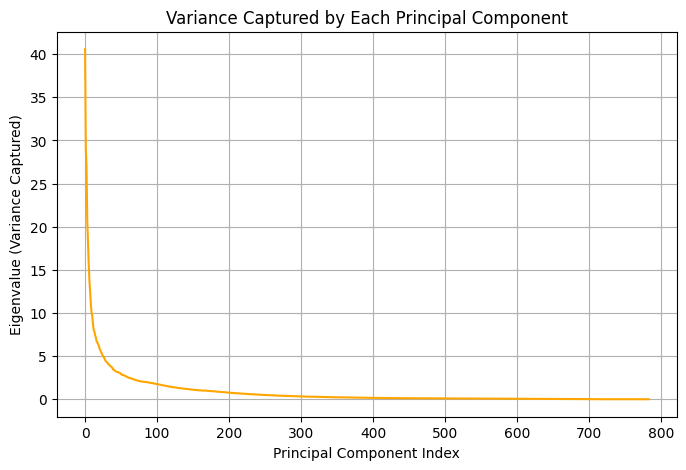

In [9]:
# Plot the eigenvalues (variance captured by each principal component)
plot_eigenvalues(eigenvalues=eigenvalues,
                 title='Variance Captured by Each Principal Component', marker='')

## 3.3 Cumulative Explained Variance

* We plot the cumulative explained variance using `cumulative_explained_variance` to visualize the tradeoff between dimensionality reduction and information loss.

* Notably, at least 8, 38, 120, and 237 components are needed to capture 25%, 50%, 75%, and 90% of the total variance in the dataset.


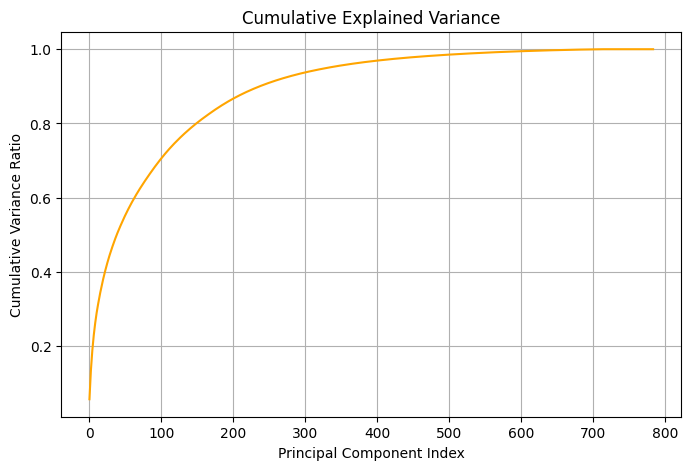

In [10]:
# Compute cumulative explained variance
cumulative_explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot cumulative explained variance
plot_cumulative_explained_variance(cumulative_explained_variance, marker='',
                                   title='Cumulative Explained Variance')

In [11]:
# Define variance thresholds
variance_thresholds = [0.25, 0.5, 0.75, 0.9]

# Find number of components needed for each threshold
components_needed = {f"{int(threshold * 100)}%": bisect_right(cumulative_explained_variance, threshold)
                     for threshold in variance_thresholds}

# Display results
for threshold, n_components in components_needed.items():
    print(f"Components needed for {threshold} variance: {n_components}")

Components needed for 25% variance: 8
Components needed for 50% variance: 38
Components needed for 75% variance: 120
Components needed for 90% variance: 237


# 4. Reconstruction and Error Analysis

* Project the standardized MNIST data onto subspaces defined by varying numbers of principal components.
* Reconstruct the data from these projections to visualize how dimensionality affects image quality.
* Quantify reconstruction quality using Mean Squared Error (MSE) for different component counts.
* Analyze the tradeoff between dimensionality reduction and information loss in PCA.

#### How projection and reconstruction work

The projected (latent) data `Z` is obtained by:

- `Z = Bᵀ X`

where:
- `Z` is the projection of the data onto the subspace of the top `M` principal components,
- `B` is an orthonormal basis (ONB) of this subspace, consisting of the first `M` eigenvectors corresponding to the largest eigenvalues.

The reconstruction of the projected data is:

- `X̂ = B Z`

The reconstruction error is defined as the Euclidean norm of the difference between the original and reconstructed data:

- `||X - X̂||`

This error is minimized by construction, since the principal components are derived to minimize the projection error (i.e., the distance from the original data to its low-dimensional approximation).


## 4.1 Projection

* We project the standardized MNIST dataset onto the first two principal components and plot the result using the `project_onto_component()` function.

* The variance (spread of data points) is greater along the first principal component, consistent with PCA's goal of maximizing variance along successive axes.

* The digits remain separated even in the reduce space. What makes it possible to use PCA for simplification of classifcation models.



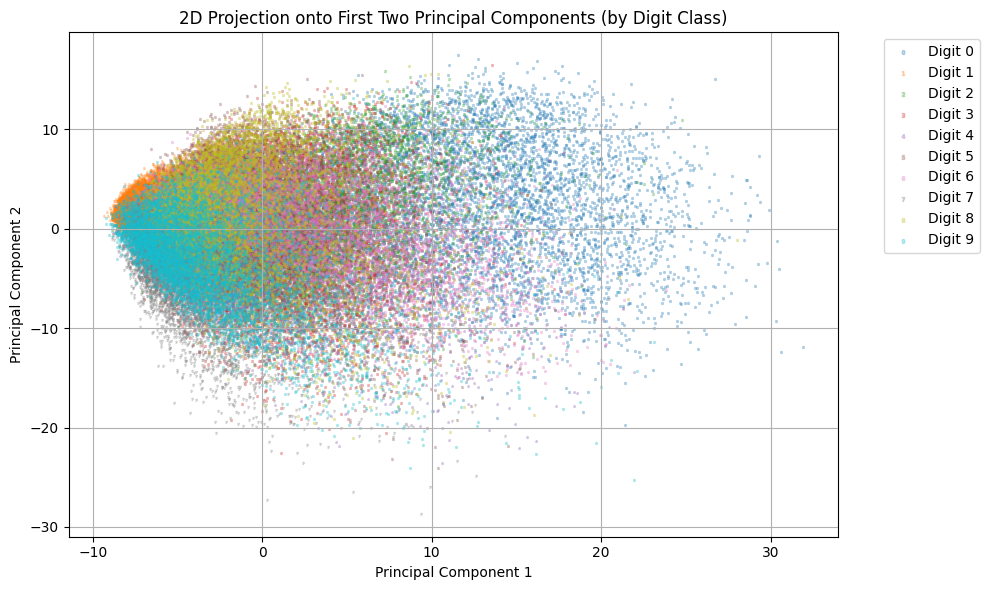

In [12]:
# Project data onto first 2 principal components
Z, basis = project_onto_components(X_standardized, eigenvectors, n_components=2)

# Visualize the 2D PCA projection with digit-specific markers
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.scatter(
        Z[y == i, 0],  # PC1
        Z[y == i, 1],  # PC2
        s=2,
        label=f'Digit {i}',
        marker=f'${i}$',
        alpha=0.3
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D Projection onto First Two Principal Components (by Digit Class)")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.2 Reconstruction from Different Variance Levels

* For each selected variance threshold (25%, 50%, 75%, 90%), we project the standardized data onto the corresponding number of principal components, reconstruct the images, and visualize a few reconstructed samples.

* The helper function `reconstruct_from_projected()` executes the projection-based reconstruction.

* The number of principal components directly affects reconstruction quality.  
  Digits become visually distinguishable at around 38 components used, which corresponds to capturing approximately 50% of the information in the data.



In [13]:
# Create dictionaries to store data about projections and reconstructions
projections={}
reconstructions_standardized={}
reconstructions={}

# Reconstruct and visualize for different variance levels
for M in components_needed.values():

    # Project onto first M components
    Z, basis = project_onto_components(X_standardized, eigenvectors, n_components=M)
    projections[M]={'data_projected':Z, 'basis':basis}

    # Reconstruct the full dataset
    X_reconstructed_standardized = reconstruct_from_projected(Z, basis)
    reconstructions_standardized[M]={'data_reconstructed_standardized': X_reconstructed_standardized}

    # Undo standardization
    X_reconstructed = undo_standardize(X_reconstructed_standardized, X_mean, X_std_dev)
    reconstructions[M]={'data_reconstructed': X_reconstructed}

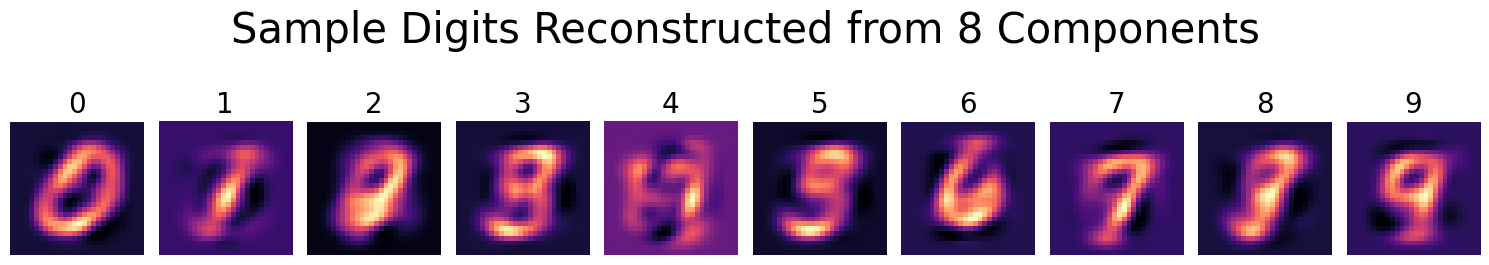

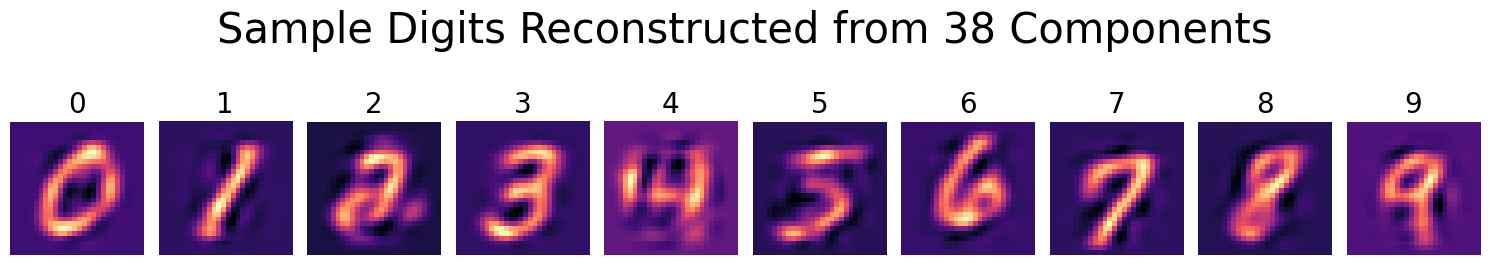

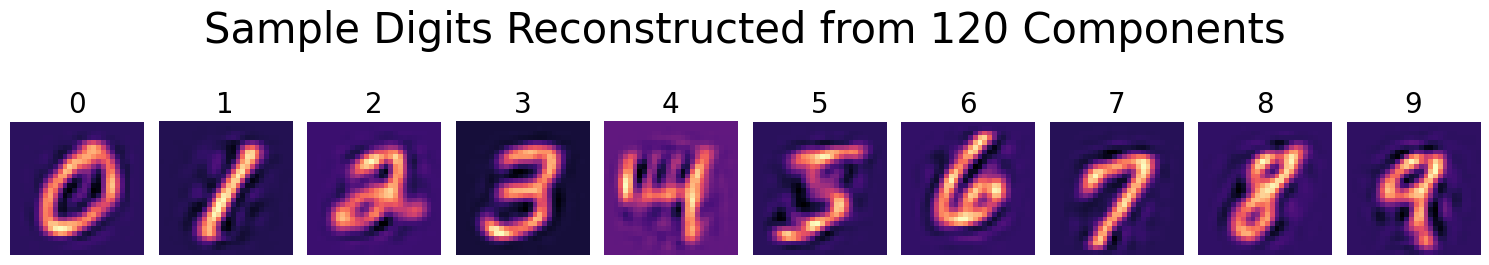

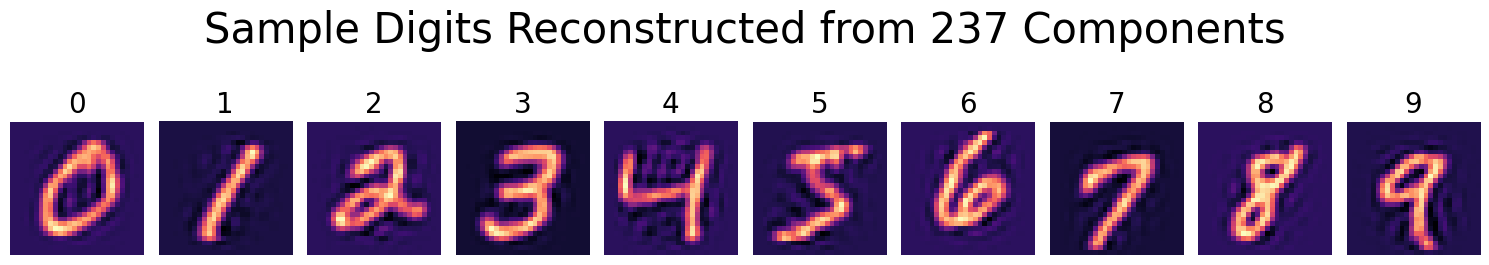

In [14]:
for M in reconstructions.keys():
    # Select sample digits for visualization
    sample_digits_reconstructed = reconstructions[M]['data_reconstructed'][sample_indexes]

    # Plot reconstructed sample digits
    plot_digits_row(
        images=sample_digits_reconstructed,
        labels=sample_labels,
        title=f"Sample Digits Reconstructed from {M} Components",
        cmap='magma'
    )

## 4.3 Reconstruction Error (MSE) vs Number of Components

* We compute the Mean Squared Error (MSE) between the original standardized data and its reconstruction using different numbers of principal components.

* As the number of components increases, the reconstruction error decreases steadily and eventually converges toward zero, reflecting near-perfect recovery of the original data.


In [15]:
# Compute MSE (reconstruction error) for different numbers of components
mse_values = {}

for idx in range(1, 28):
    M = idx ** 2

    # Project onto n_components principal components
    Z, basis = project_onto_components(X_standardized, eigenvectors, n_components=M)

    # Reconstruct the standardized data
    X_reconstructed_standardized = reconstruct_from_projected(Z, basis)

    # Compute mean squared error
    mse = np.mean((X_standardized - X_reconstructed_standardized) ** 2)
    mse_values[M] = mse

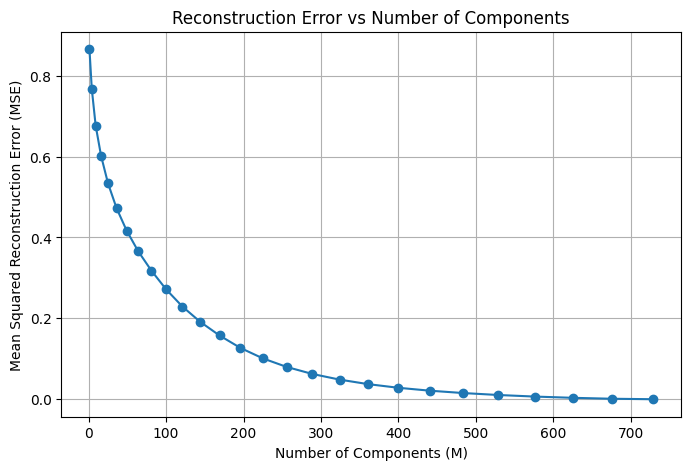

In [16]:
# Plot MSE vs Number of Components
plt.figure(figsize=(8, 5))
plt.plot(mse_values.keys(), mse_values.values(), marker='o')
plt.xlabel('Number of Components (M)')
plt.ylabel('Mean Squared Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs Number of Components')
plt.grid(True)
plt.show()

# 5. Digit Generation and Class-Specific PCA
* Generate synthetic digit images by sampling from PCA subspace.
* Compare global PCA generation (across all digits) with class-specific generation (digit 2 only).
* Analyze how subspace dimensionality affects generation quality and noise.
* Demonstrate that class-specific PCA yields clearer and more realistic samples than global PCA.


## 5.1 Generation from Global PCA (All Digits)

* For each selected variance threshold (25%, 50%, 75%, 90%), we alternatively generate digits from corresponding PCA subspace.

*  This process is performed by the helper function `generate_samples_from_pca()`. The function computes the mean and covariance of the projected data, then sample new observations from a multivariate normal distribution using these parameters and reconstruct the corresponding digits.

* We observe that digits generated from the global PCA subspace are blurry and largely indistinguishable. In fact, as the dimensionality of the subspace increases, the generated digits become increasingly noisy and less digit-like.

* This behavior is expected: global PCA captures mixed variance across all digit classes (0–9), which leads to entangled structure in the latent space. Meaningful generation typically requires class-specific PCA or more expressive generative models such as VAEs or GANs.



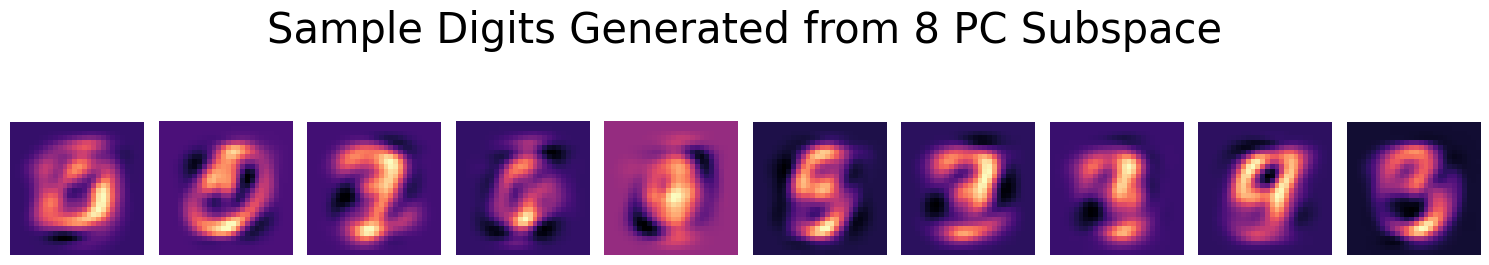

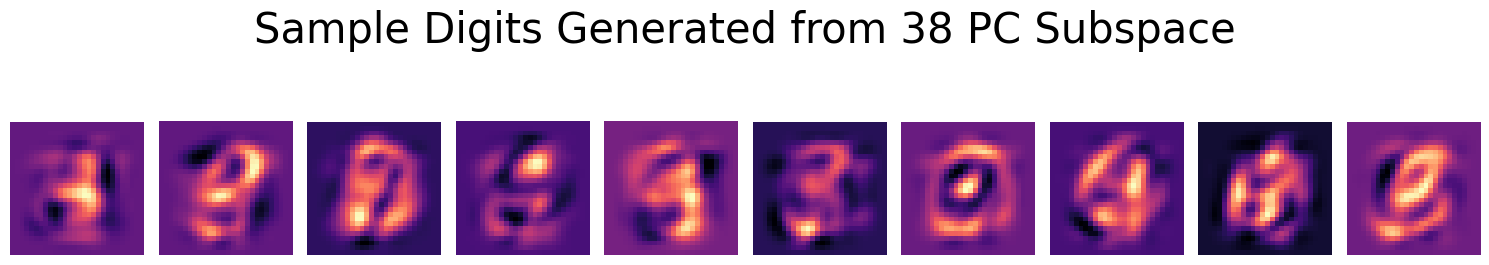

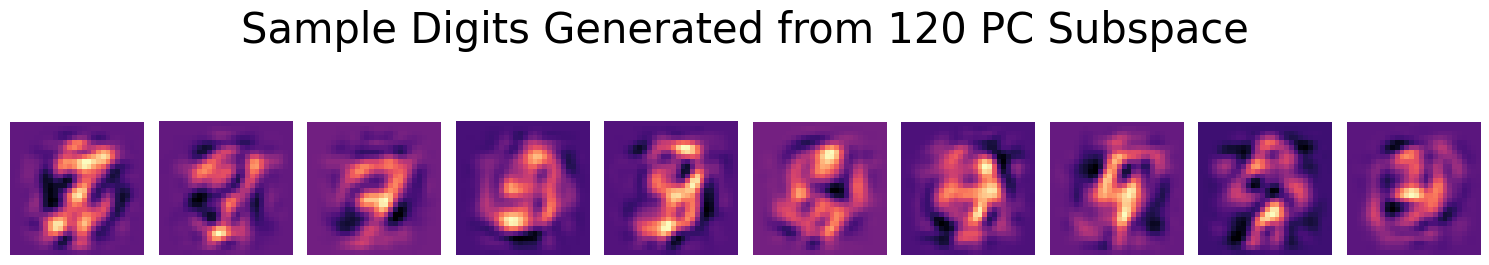

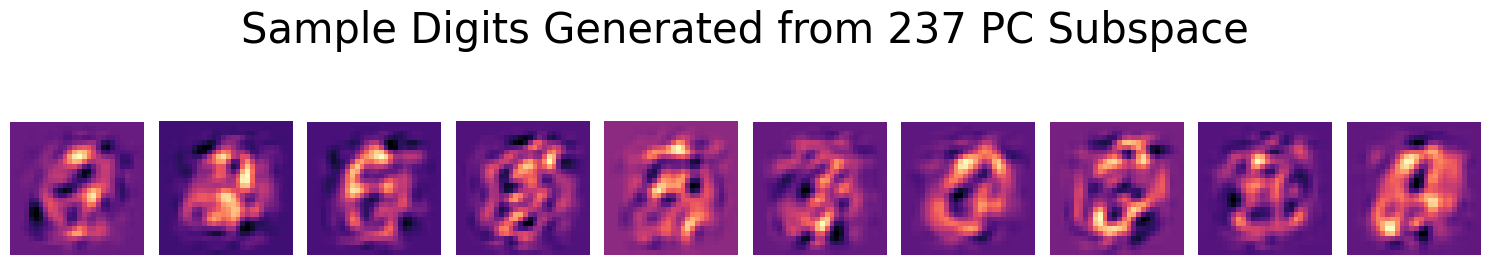

In [17]:
for M in components_needed.values():
  generated_samples=generate_samples_from_pca(projections[M]['data_projected'],
                                              projections[M]['basis'],
                                              X_mean, X_std_dev, n_samples=10)
  plot_digits_row(generated_samples,
                  title=f"Sample Digits Generated from {M} PC Subspace",
                  cmap='magma')

## 5.2 Prepare Class-Specific Data (Digit 2)

* We isolate all images corresponding to the digit 2 and standardize them.

* When repeating PCA on this class-specific subset, we observe that the eigenvalues are smaller overall, indicating lower variance — which is expected, as the data is more uniform within a single digit class.

* As a result, fewer principal components are required to capture the same amount of variance compared to the global dataset.

In [18]:
# Extract all images corresponding to digit 2
digit2 = X[y == 2]

# Standardize the digit 2 data
digit2_standardized, digit2_mean, digit2_std_dev = standardize(digit2)

print(f"Shape of standardized digit 2 data: {digit2_standardized.shape}")

Shape of standardized digit 2 data: (6990, 784)


In [19]:
# Perform PCA on digit 2 data
digit2_eigenvalues, digit2_eigenvectors = compute_pca(digit2_standardized)

print(f"Eigenvalues shape: {digit2_eigenvalues.shape}")
print(f"Eigenvectors shape: {digit2_eigenvectors.shape}")

Eigenvalues shape: (784,)
Eigenvectors shape: (784, 784)


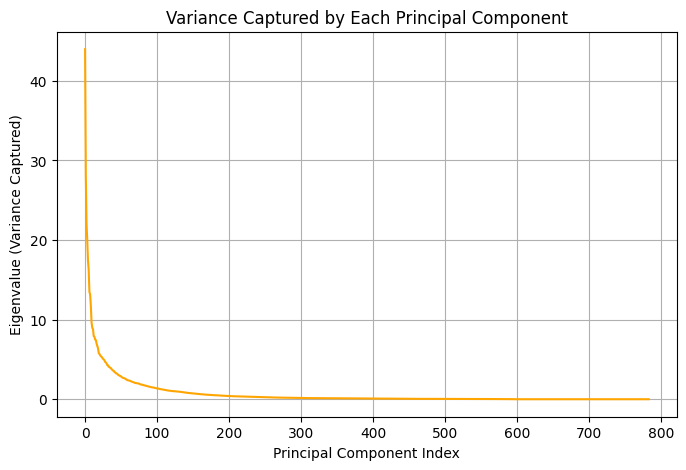

In [21]:
# Plot the eigenvalues (variance captured by each principal component)
plot_eigenvalues(eigenvalues=digit2_eigenvalues,
                 title='Variance Captured by Each Principal Component', marker='')

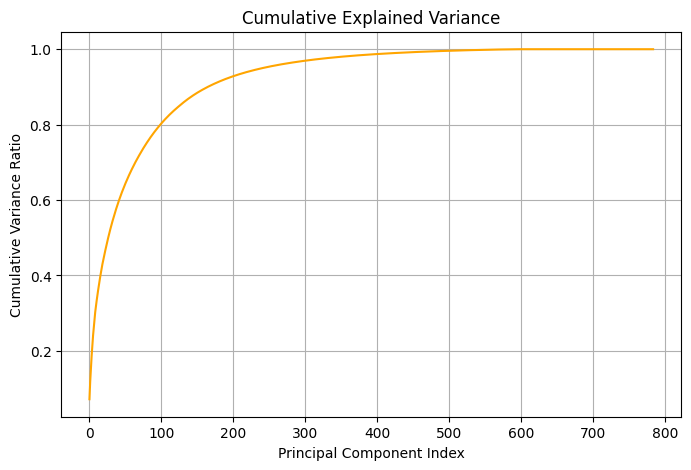

In [22]:
# Plot cumulative explained variance
cumulative_explained_variance_digit2 = np.cumsum(digit2_eigenvalues) / np.sum(digit2_eigenvalues)

# Plot cumulative explained variance
plot_cumulative_explained_variance(cumulative_explained_variance_digit2, marker='',
                                   title='Cumulative Explained Variance')

## 5.3 Generate Class-Specific Data (Digit 2)

* We generate digit 2 images from subspaces of different dimensions and observe that, despite the number of components, the generated samples remain visually distinguishable and resemble the digit 2.

* However, it is easy to notice the appearance of noise as the number of components increases. This takes place because higher-dimensional subspaces capture more variance — but also include noisy directions.

* As a result, generated digits may exhibit more artifacts or unnatural distortions when sampling from a high-dimensional latent space. This illustrates the tradeoff between variance preservation and generation quality in PCA-based generating models.


In [23]:
#Define the number of components for each generation round
components_digit2=[2, 4, 8, 16, 32, 64, 128]

# Generate digits for each variance level
generated_digits_digit2 = {}

for M in components_digit2:
    # Project the digit 2 data onto top n_components
    data_projected, basis = project_onto_components(digit2_standardized, digit2_eigenvectors, n_components)

    # Generate new samples
    generated_samples = generate_samples_from_pca(data_projected, basis, digit2_mean, digit2_std_dev, n_samples=10)
    generated_digits_digit2[M] = generated_samples

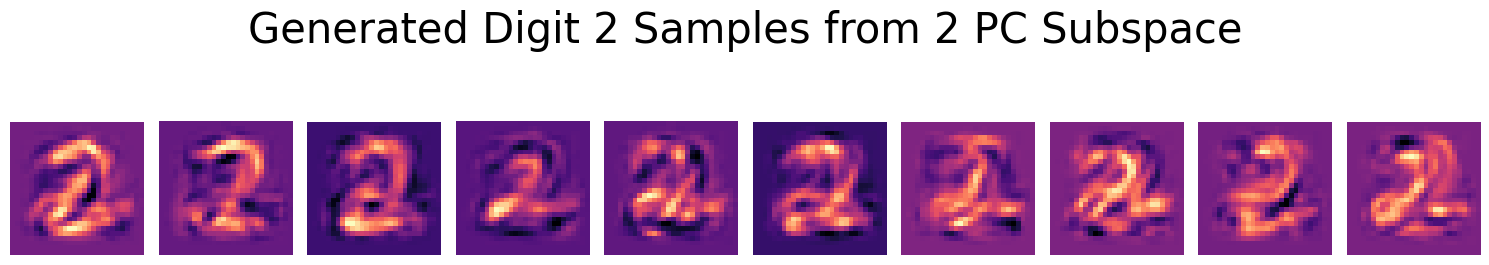

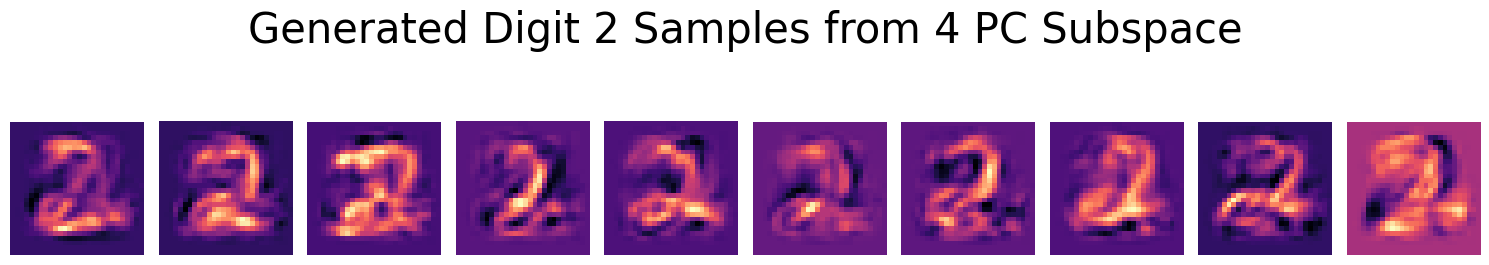

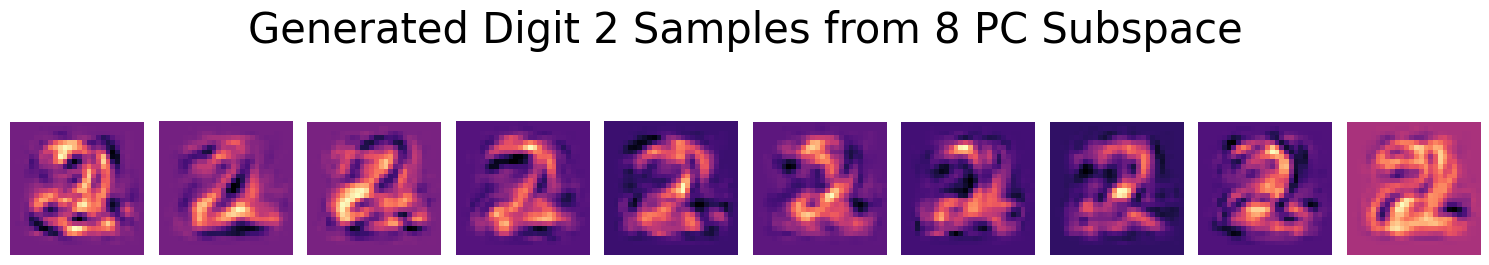

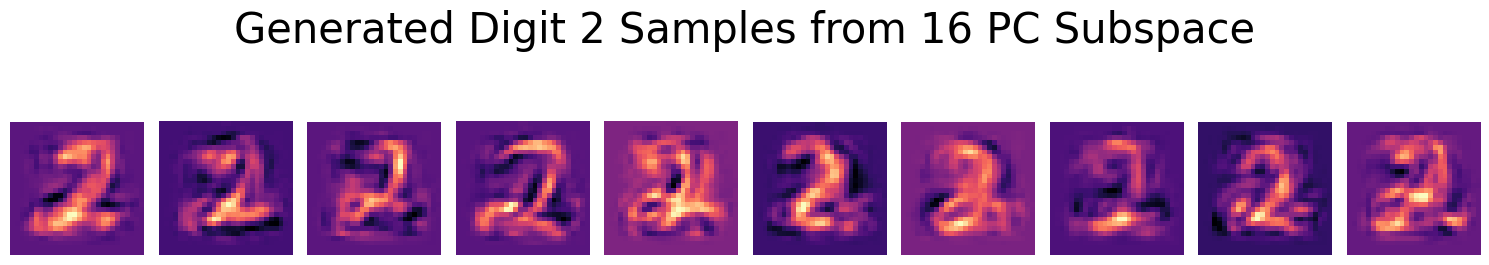

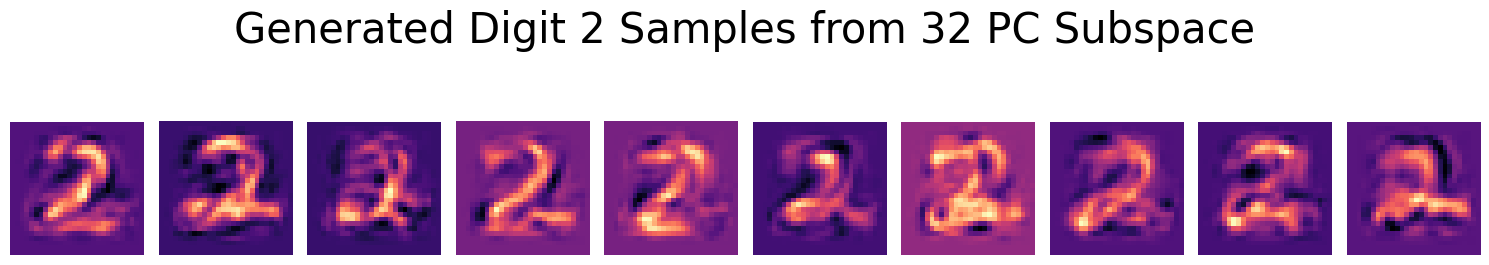

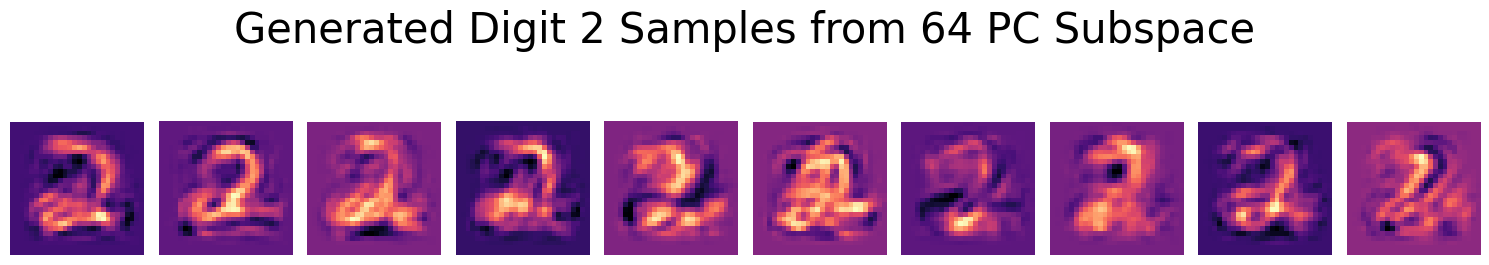

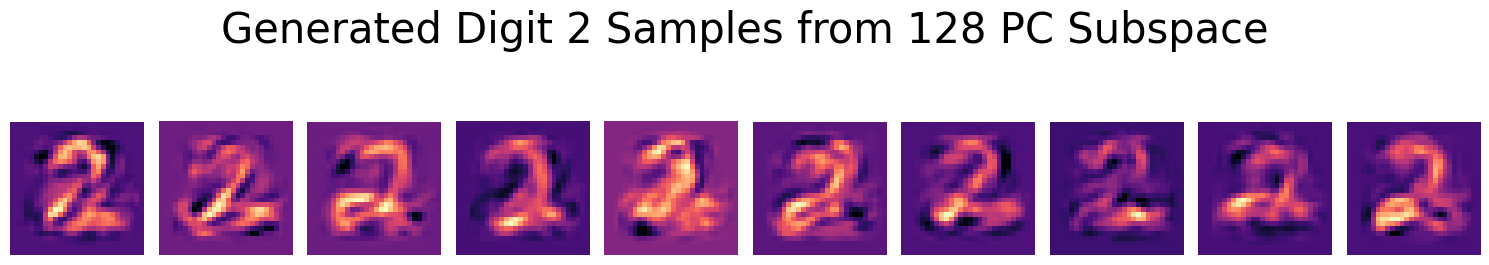

In [24]:
# Visualize generated samples
for M in components_digit2:
  plot_digits_row(generated_digits_digit2[M],
                  title=f"Generated Digit 2 Samples from {M} PC Subspace",
                  cmap='magma')